In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Input, Dense
from keras.models import Model

+ a simple autoencoder based on a fully-connected layer
+ a sparse autoencoder
+ a deep fully-connected autoencoder
+ a deep convolutional autoencoder
+ an image denoising model
+ a sequence-to-sequence autoencoder
+ a variational autoencoder

<img src="Images/Enocoder.png">

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 

+ 1) data-specific, 

+ 2) lossy, and 

+ 3) learned automatically from examples rather than engineered by a human. 

To build an autoencoder, you need three things: 

+ an encoding function, 
+ a decoding function,
+ distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

What are autoencoders good for?
They are rarely used in practical applications. In 2012 they briefly found an application in greedy layer-wise pretraining for deep convolutional neural networks [1], but this quickly fell out of fashion as we started realizing that better random weight initialization schemes were sufficient for training deep networks from scratch. In 2014, batch normalization [2] started allowing for even deeper networks, and from late 2015 we could train arbitrarily deep networks from scratch using residual learning [3].

Today two interesting practical applications of autoencoders are 

+ 1. data denoising (which we feature later in this post), 
+ 2. dimensionality reduction for data visualization.

With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on Github. Otherwise scikit-learn also has a simple and practical implementation.

In self-supervized learning applied to vision, a potentially fruitful alternative to autoencoder-style input reconstruction is the use of toy tasks such as jigsaw puzzle solving, or detail-context matching (being able to match high-resolution but small patches of pictures with low-resolution versions of the pictures they are extracted from). The following paper investigates jigsaw puzzle solving and makes for a very interesting read: Noroozi and Favaro (2016) Unsupervised Learning of Visual Representations by Solving Jigsaw Puzzles. Such tasks are providing the model with built-in assumptions about the input data which are missing in traditional autoencoders, such as "visual macro-structure matters more than pixel-level details".

## Simple Auto Encoder

<img src="Images/basic_autoencoder.jpg">

In [5]:
# thisis the size of our encoded representations
encoding_dim = 32 # 

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded rep of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

#this model maps an input to its encoded rep
encoder = Model(input_img, encoded)

#"decoded is the lossy reconstruction of the input"
decoded = Dense(784, activation='sigmoid')(encoded)



# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# create a placehoder for an encoded (32-dim) input
encoded_input = Input(shape=(encoding_dim,))

# retrive the last of the autencoder model
decoder_layer = autoencoder.layers[-1]
all_layer = autoencoder.layers

#create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
# Let's prepare our input data. Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

In [59]:
autoencoder.fit(x_train, x_train,
               epochs=50, 
               batch_size = 256,
               shuffle=True,
               validation_split=.15)

Train on 51000 samples, validate on 9000 samples
Epoch 1/50
51000/51000 [==============================] - 1s 29us/step - loss: 0.0982 - val_loss: 0.0985
Epoch 2/50
51000/51000 [==============================] - 1s 26us/step - loss: 0.0981 - val_loss: 0.0985
Epoch 3/50
51000/51000 [==============================] - 1s 26us/step - loss: 0.0981 - val_loss: 0.0984
Epoch 4/50
51000/51000 [==============================] - 1s 27us/step - loss: 0.0980 - val_loss: 0.0983
Epoch 5/50
51000/51000 [==============================] - 1s 27us/step - loss: 0.0979 - val_loss: 0.0983
Epoch 6/50
51000/51000 [==============================] - 1s 27us/step - loss: 0.0979 - val_loss: 0.0982
Epoch 7/50
51000/51000 [==============================] - 1s 27us/step - loss: 0.0978 - val_loss: 0.0981
Epoch 8/50
51000/51000 [==============================] - 1s 26us/step - loss: 0.0977 - val_loss: 0.0981
Epoch 9/50
51000/51000 [==============================] - 1s 27us/step - loss: 0.0977 - val_loss: 0.0980
Epoch 

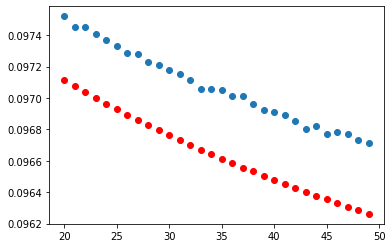

In [62]:
train_loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
plt.scatter(autoencoder.history.epoch[20:],train_loss[20:],c='r')
plt.scatter(autoencoder.history.epoch[20:],val_loss[20:])

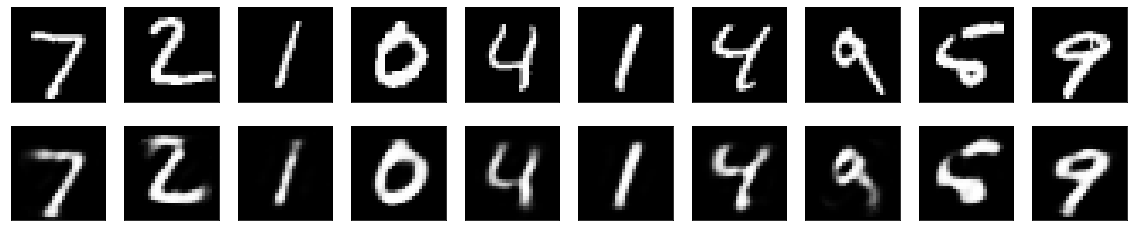

In [65]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10
plt.figure(figsize=(20 ,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding a sparsity constraint on the encoded representations

## Add regularization

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [73]:
from keras import regularizers

In [80]:
# thisis the size of our encoded representations
encoding_dim = 32 # 

# this is our input placeholder
input_img = Input(shape=(784,))

#### right here the change to regularizationg

# "encoded" is the encoded rep of the input
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-8))(input_img)

#this model maps an input to its encoded rep
encoder = Model(input_img, encoded)

#"decoded is the lossy reconstruction of the input"
decoded = Dense(784, activation='sigmoid')(encoded)



# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# create a placehoder for an encoded (32-dim) input
encoded_input = Input(shape=(encoding_dim,))

# retrive the last of the autencoder model
decoder_layer = autoencoder.layers[-1]
all_layer = autoencoder.layers

#create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [81]:
# Let's prepare our input data. Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [82]:
autoencoder.fit(x_train, x_train,
               epochs=100, 
               batch_size = 256,
               shuffle=True,
               validation_split=.15)

Train on 51000 samples, validate on 9000 samples
Epoch 1/100
51000/51000 [==============================] - 1s 29us/step - loss: 0.3785 - val_loss: 0.2753
Epoch 2/100
51000/51000 [==============================] - 1s 25us/step - loss: 0.2713 - val_loss: 0.2628
Epoch 3/100
51000/51000 [==============================] - 1s 25us/step - loss: 0.2563 - val_loss: 0.2453
Epoch 4/100
51000/51000 [==============================] - 1s 24us/step - loss: 0.2379 - val_loss: 0.2271
Epoch 5/100
51000/51000 [==============================] - 1s 24us/step - loss: 0.2214 - val_loss: 0.2126
Epoch 6/100
51000/51000 [==============================] - 1s 27us/step - loss: 0.2088 - val_loss: 0.2017
Epoch 7/100
51000/51000 [==============================] - 1s 26us/step - loss: 0.1993 - val_loss: 0.1937
Epoch 8/100
51000/51000 [==============================] - 1s 26us/step - loss: 0.1920 - val_loss: 0.1872
Epoch 9/100
51000/51000 [==============================] - 1s 27us/step - loss: 0.1862 - val_loss: 0.18

51000/51000 [==============================] - 1s 23us/step - loss: 0.1079 - val_loss: 0.1080
Epoch 78/100
51000/51000 [==============================] - 1s 23us/step - loss: 0.1078 - val_loss: 0.1079
Epoch 79/100
51000/51000 [==============================] - 1s 23us/step - loss: 0.1076 - val_loss: 0.1077
Epoch 80/100
51000/51000 [==============================] - 1s 24us/step - loss: 0.1075 - val_loss: 0.1076
Epoch 81/100
51000/51000 [==============================] - 1s 28us/step - loss: 0.1074 - val_loss: 0.1075
Epoch 82/100
51000/51000 [==============================] - 1s 26us/step - loss: 0.1073 - val_loss: 0.1074
Epoch 83/100
51000/51000 [==============================] - 2s 30us/step - loss: 0.1071 - val_loss: 0.1073
Epoch 84/100
51000/51000 [==============================] - 1s 25us/step - loss: 0.1070 - val_loss: 0.1071
Epoch 85/100
51000/51000 [==============================] - 1s 25us/step - loss: 0.1069 - val_loss: 0.1070
Epoch 86/100
51000/51000 [========================

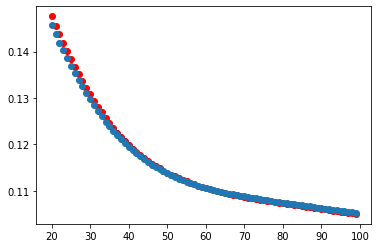

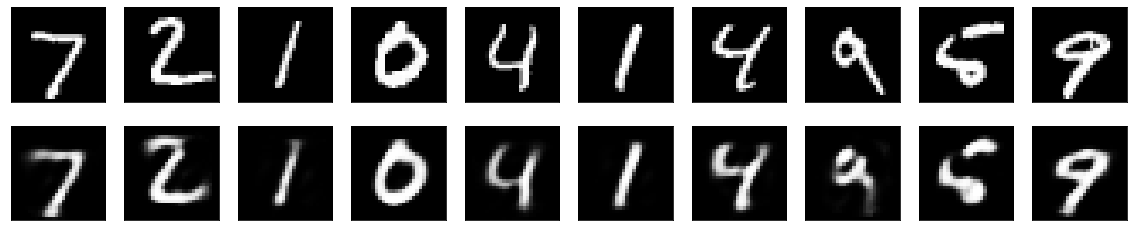

In [83]:
train_loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
plt.scatter(autoencoder.history.epoch[20:],train_loss[20:],c='r')
plt.scatter(autoencoder.history.epoch[20:],val_loss[20:])
######
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10
plt.figure(figsize=(20 ,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [87]:
decoded_imgs.mean()

0.13337705

## Deep autoencoder

In [93]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

#this model maps an input to its encoded rep
encoder = Model(input_img, encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)





In [95]:
autoencoder = Model(input_img, decoded)


# thisis the size of our encoded representations
encoding_dim = 32 
# create a placehoder for an encoded (32-dim) input
encoded_input = Input(shape=(encoding_dim,))

# retrive the last of the autencoder model
decoder_layer_1 = autoencoder.layers[-3]
decoder_layer_2 = autoencoder.layers[-2]
decoder_layer_3 = autoencoder.layers[-1]
all_layer = autoencoder.layers

#create the decoder model
decoder = Model(encoded_input, decoder_layer_3(decoder_layer_2(decoder_layer_1(encoded_input))))


autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
               epochs=150,
               batch_size=256,
               shuffle=True,
               validation_split=.15)

Train on 51000 samples, validate on 9000 samples
Epoch 1/150
51000/51000 [==============================] - 3s 53us/step - loss: 0.2498 - val_loss: 0.2409
Epoch 2/150
51000/51000 [==============================] - 2s 43us/step - loss: 0.2301 - val_loss: 0.2216
Epoch 3/150
51000/51000 [==============================] - 2s 39us/step - loss: 0.2163 - val_loss: 0.2113
Epoch 4/150
51000/51000 [==============================] - 2s 37us/step - loss: 0.2063 - val_loss: 0.2002
Epoch 5/150
51000/51000 [==============================] - 2s 40us/step - loss: 0.1971 - val_loss: 0.1945
Epoch 6/150
51000/51000 [==============================] - 3s 67us/step - loss: 0.1890 - val_loss: 0.1843
Epoch 7/150
51000/51000 [==============================] - 3s 59us/step - loss: 0.1811 - val_loss: 0.1776
Epoch 8/150
51000/51000 [==============================] - 2s 49us/step - loss: 0.1749 - val_loss: 0.1726
Epoch 9/150
51000/51000 [==============================] - 2s 49us/step - loss: 0.1705 - val_loss: 0.16

51000/51000 [==============================] - 2s 35us/step - loss: 0.1068 - val_loss: 0.1074
Epoch 78/150
51000/51000 [==============================] - 2s 35us/step - loss: 0.1066 - val_loss: 0.1065
Epoch 79/150
51000/51000 [==============================] - 2s 35us/step - loss: 0.1063 - val_loss: 0.1076
Epoch 80/150
51000/51000 [==============================] - 2s 35us/step - loss: 0.1061 - val_loss: 0.1064
Epoch 81/150
51000/51000 [==============================] - 2s 36us/step - loss: 0.1059 - val_loss: 0.1065
Epoch 82/150
51000/51000 [==============================] - 2s 37us/step - loss: 0.1056 - val_loss: 0.1067
Epoch 83/150
51000/51000 [==============================] - 2s 36us/step - loss: 0.1055 - val_loss: 0.1061
Epoch 84/150
51000/51000 [==============================] - 2s 36us/step - loss: 0.1052 - val_loss: 0.1061
Epoch 85/150
51000/51000 [==============================] - 2s 36us/step - loss: 0.1051 - val_loss: 0.1066
Epoch 86/150
51000/51000 [========================

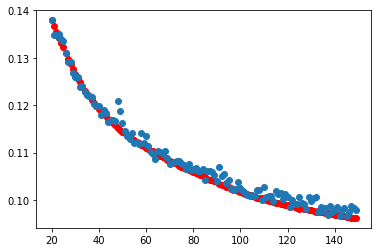

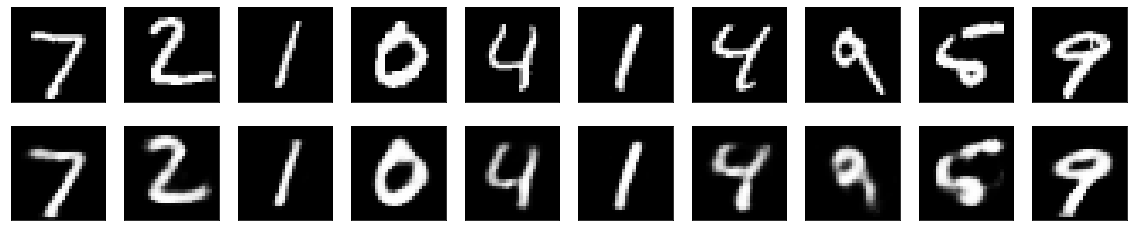

In [96]:
train_loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
plt.scatter(autoencoder.history.epoch[20:],train_loss[20:],c='r')
plt.scatter(autoencoder.history.epoch[20:],val_loss[20:])
######
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10
plt.figure(figsize=(20 ,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional Auto encoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [97]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


In [132]:
input_img = Input(shape=(28,28,1))
# now (28, 28, 1)
x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
# now (28,28,16)
x = MaxPooling2D((2,2), padding='same')(x)
# now (14,14,16)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
# now (13,13,8)
x = MaxPooling2D((2,2), padding='same')(x)
# now (7,7,8)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
# now (7, 7, 8)
encoded = MaxPooling2D((2,2), padding='same')(x)
# now (4, 4, 8)

encoder = Model(input_img, encoded)

# at this point the representation is (4,4,8) i.e. 128-dim

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
print(x)
# now (4, 4, 8)
x = UpSampling2D((2,2))(x)
print(x)
# now (8, 8, 8)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
print(x)
# now (8, 8, 8)
x = UpSampling2D((2,2))(x)
print(x)
# now (16, 16, 8)
x = Conv2D(16, (3,3), activation='relu')(x)
print(x)
# now (14, 14, 16)
x = UpSampling2D((2,2))(x)
print(x)
# now (28, 28, 16)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
print(decoded)
# now (28, 28, 1)

autoencoder = Model(input_img, decoded)



# thisis the size of our encoded representations
encoding_dim = (4,4,8) 
# create a placehoder for an encoded (32-dim) input
encoded_input = Input(shape=encoding_dim)

# retrive the last of the autencoder model
decoder_layer_1 = autoencoder.layers[-7]
decoder_layer_2 = autoencoder.layers[-6]
decoder_layer_3 = autoencoder.layers[-5]
decoder_layer_4 = autoencoder.layers[-4]
decoder_layer_5 = autoencoder.layers[-3]
decoder_layer_6 = autoencoder.layers[-2]
decoder_layer_7 = autoencoder.layers[-1]
all_layer = autoencoder.layers

#create the decoder model
decoder = Model(encoded_input, decoder_layer_7(decoder_layer_6(decoder_layer_5(decoder_layer_4(decoder_layer_3(decoder_layer_2(decoder_layer_1(encoded_input))))))))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Tensor("conv2d_39/Relu:0", shape=(None, 4, 4, 8), dtype=float32)
Tensor("up_sampling2d_13/ResizeNearestNeighbor:0", shape=(None, 8, 8, 8), dtype=float32)
Tensor("conv2d_40/Relu:0", shape=(None, 8, 8, 8), dtype=float32)
Tensor("up_sampling2d_14/ResizeNearestNeighbor:0", shape=(None, 16, 16, 8), dtype=float32)
Tensor("conv2d_41/Relu:0", shape=(None, 14, 14, 16), dtype=float32)
Tensor("up_sampling2d_15/ResizeNearestNeighbor:0", shape=(None, 28, 28, 16), dtype=float32)
Tensor("conv2d_42/Sigmoid:0", shape=(None, 28, 28, 1), dtype=float32)


In [133]:
# Let's prepare our input data. Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [109]:
#!tensorboard --logdir=/tmp/autoencoder

In [134]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_split=.15,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 51000 samples, validate on 9000 samples
Epoch 1/50
51000/51000 [==============================] - 45s 885us/step - loss: 0.2153 - val_loss: 0.1745
Epoch 2/50
51000/51000 [==============================] - 44s 862us/step - loss: 0.1600 - val_loss: 0.1486
Epoch 3/50
51000/51000 [==============================] - 44s 863us/step - loss: 0.1446 - val_loss: 0.1420
Epoch 4/50
51000/51000 [==============================] - 44s 862us/step - loss: 0.1363 - val_loss: 0.1346
Epoch 5/50
51000/51000 [==============================] - 44s 862us/step - loss: 0.1312 - val_loss: 0.1315
Epoch 6/50
51000/51000 [==============================] - 44s 861us/step - loss: 0.1274 - val_loss: 0.1271
Epoch 7/50
51000/51000 [==============================] - 44s 865us/step - loss: 0.1247 - val_loss: 0.1223
Epoch 8/50
51000/51000 [==============================] - 44s 864us/step - loss: 0.1222 - val_loss: 0.1212
Epoch 9/50
51000/51000 [==============================] - 44s 864us/step - loss: 0.1199 - val_l

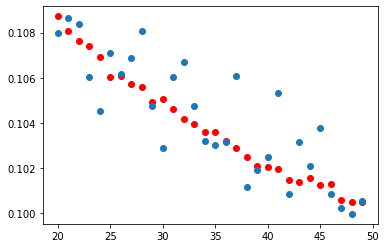

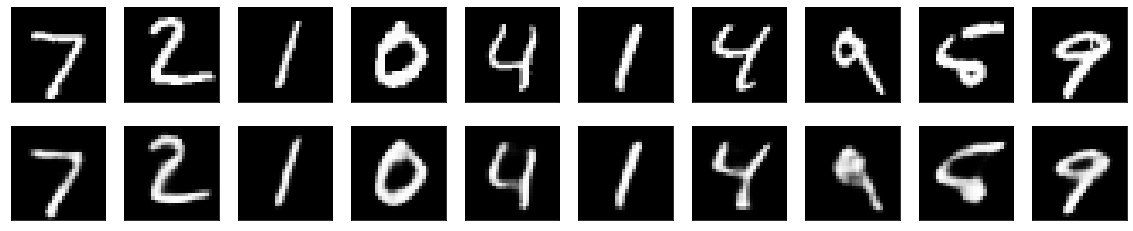

In [135]:
train_loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
plt.scatter(autoencoder.history.epoch[20:],train_loss[20:],c='r')
plt.scatter(autoencoder.history.epoch[20:],val_loss[20:])
######
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20 ,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [150]:
encoded_imgs = encoder.predict(x_test)

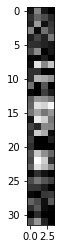

In [154]:
plt.imshow(encoded_imgs[0].reshape(4, 4 * 8).T)

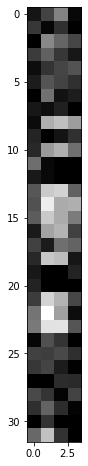

In [156]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
#     ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
plt.show()